In [1]:
# Librerías base
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Preprocesamiento y modelos
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    roc_auc_score
)

import time
from pprint import pprint

RANDOM_STATE = 42

from IPython.display import display


from utils import *

In [2]:
df = pd.read_csv("data-churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape, df.columns.tolist()

((7043, 21),
 ['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges',
  'Churn'])

In [4]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df["Churn"].value_counts(dropna=False)

Churn
0    5174
1    1869
Name: count, dtype: int64

### Variable objetivo

La variable objetivo `Churn` se encuentra originalmente codificada como una variable categórica ("Yes"/"No"). Para su uso en modelos de clasificación binaria, se transforma a una representación numérica, tal como en la primera actividad donde:

- 1 indica que el cliente abandona (churn)
- 0 indica que el cliente permanece

Posteriormente, se analiza la distribución de clases para identificar un posible desbalance,
lo cual es relevante para la selección de métricas de evaluación y estrategias de modelado.

In [5]:
# Revisar faltantes
(df.isna().sum().sort_values(ascending=False).head(15))

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

### Análisis de valores faltantes

Se revisa la presencia de valores faltantes en el conjunto de datos con el objetivo de
definir una estrategia de imputación adecuada dentro del pipeline de preprocesamiento.
El análisis muestra que los valores faltantes son escasos y se concentran en pocas variables,
por lo que se opta por imputación simple.

In [6]:
target = "Churn"

numeric_features = df.drop(columns=[target]).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.drop(columns=[target]).select_dtypes(exclude=[np.number]).columns.tolist()



### Identificación de variables numéricas y categóricas

Se separan las variables predictoras en numéricas y categóricas, excluyendo la variable
objetivo `Churn`, con el fin de aplicar transformaciones diferenciadas dentro del pipeline
de preprocesamiento. Las variables numéricas se tratarán mediante imputación simple, mientras
que las variables categóricas serán codificadas usando One-Hot Encoding.

In [7]:
X = df.drop(columns=[target]).copy()
y = df[target].copy()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

### Preprocesamiento de datos

Se separan las variables predictoras (`X`) y la variable objetivo (`y`). Posteriormente,
se define un pipeline de preprocesamiento que aplica transformaciones diferenciadas a
variables numéricas y categóricas.

Las variables numéricas son imputadas usando la mediana y escaladas mediante
estandarización. Las variables categóricas son imputadas con la categoría más frecuente
y codificadas mediante One-Hot Encoding. Todo el preprocesamiento se integra mediante
un `ColumnTransformer`, garantizando su correcta aplicación dentro de validación cruzada
y evitando fugas de información.


## Paso 2. Árbol de decisión: Grid Search vs Random Search

In [8]:
pipe_dt = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt = {
    "clf__max_depth": [None, 3, 5, 8, 12, 16],
    "clf__min_samples_split": [2, 10, 25, 50],
    "clf__min_samples_leaf": [1, 5, 10, 25],
    "clf__criterion": ["gini", "entropy", "log_loss"]
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = "average_precision"  

param_grid_dt

{'clf__max_depth': [None, 3, 5, 8, 12, 16],
 'clf__min_samples_split': [2, 10, 25, 50],
 'clf__min_samples_leaf': [1, 5, 10, 25],
 'clf__criterion': ['gini', 'entropy', 'log_loss']}

### Árbol de decisión y selección de hiperparámetros

Se implementa un árbol de decisión de clasificación integrado a un pipeline que incluye
el preprocesamiento de los datos. Para controlar el sobreajuste y explorar distintos
niveles de complejidad del modelo, se define una grilla de hiperparámetros que considera
la profundidad máxima del árbol, el tamaño mínimo de los nodos y el criterio de división.

La selección de hiperparámetros se realiza mediante validación cruzada estratificada de
5 folds, utilizando como métrica principal el área bajo la curva Precision–Recall
(PR-AUC), adecuada para problemas con clases desbalanceadas.

In [9]:
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
grid_dt.fit(X, y)
grid_time = time.perf_counter() - t0

print("GridSearchCV time (s):", round(grid_time, 3))
print("Best params (Grid):")
pprint(grid_dt.best_params_)
print("Best score (Grid):", grid_dt.best_score_)

GridSearchCV time (s): 136.671
Best params (Grid):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}
Best score (Grid): 0.6175695372935053


El Grid Search identifica como mejor configuración un árbol de profundidad moderada
(max_depth = 8) con hojas relativamente grandes (min_samples_leaf = 25), lo que sugiere
que controlar la complejidad del modelo es fundamental para evitar sobreajuste en el
problema de churn.

El valor de PR-AUC obtenido (≈ 0.62) indica una capacidad razonable del modelo para
identificar clientes con mayor probabilidad de abandono, superando ampliamente el
desempeño esperado de un clasificador aleatorio. Sin embargo, el tiempo de ejecución
resulta elevado, lo que motiva la comparación con métodos de búsqueda más eficientes
como RandomizedSearchCV.


In [10]:
rand_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_grid_dt,
    n_iter=50,                 # ajuste según recursos
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_dt.fit(X, y)
rand_time = time.perf_counter() - t0

print("RandomizedSearchCV time (s):", round(rand_time, 3))
print("Best params (Random):")
pprint(rand_dt.best_params_)
print("Best score (Random):", rand_dt.best_score_)

RandomizedSearchCV time (s): 32.512
Best params (Random):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 10}
Best score (Random): 0.6175695372935053


La comparación entre GridSearchCV y RandomizedSearchCV muestra que ambos métodos
identifican configuraciones de hiperparámetros con desempeño prácticamente idéntico
(PR-AUC ≈ 0.62). Sin embargo, RandomizedSearchCV logra este resultado con un costo
computacional significativamente menor, reduciendo el tiempo de ejecución en más de
un 75%.

Esto sugiere que, para modelos con múltiples hiperparámetros y espacios de búsqueda
amplios, la búsqueda aleatoria constituye una alternativa más eficiente sin pérdida
de desempeño predictivo.


In [11]:
# Comparación directa: tiempos y scores
comparison_search = pd.DataFrame({
    "method": ["GridSearchCV", "RandomizedSearchCV"],
    "time_s": [grid_time, rand_time],
    "best_score(PR-AUC)": [grid_dt.best_score_, rand_dt.best_score_]
}).sort_values("best_score(PR-AUC)", ascending=False)

comparison_search

,method,time_s,best_score(PR-AUC)
0,GridSearchCV,136.670749,0.61757
1,RandomizedSearchCV,32.512166,0.61757


### Comparación Grid Search vs Random Search

La Tabla muestra una comparación directa entre GridSearchCV y RandomizedSearchCV en
términos de desempeño predictivo y costo computacional. Ambos métodos alcanzan un
PR-AUC idéntico (≈ 0.62), lo que indica que la búsqueda aleatoria logra identificar
configuraciones de hiperparámetros tan efectivas como la búsqueda exhaustiva.

No obstante, RandomizedSearchCV reduce el tiempo de ejecución en más de un 75%,
lo que lo convierte en una alternativa más eficiente para la selección de
hiperparámetros en este problema.


### 2.3 Evaluación final del mejor árbol (CV)


Mejor método: GridSearchCV
Mejores hiperparámetros:
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}


,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,0.168300,0.031776,0.789212,0.608451,0.577540,0.592593,0.828351,0.631010
1,2,0.153589,0.024890,0.785664,0.606509,0.548128,0.575843,0.817486,0.616146
2,3,0.146999,0.024586,0.797729,0.639498,0.545455,0.588745,0.827300,0.650971
3,4,0.140363,0.026761,0.774858,0.590323,0.490617,0.535871,0.799156,0.560033
4,5,0.142740,0.025573,0.793324,0.631746,0.532086,0.577649,0.822886,0.629687


,mean,std
fit_time_s,0.150398,0.011198
pred_time_s,0.026717,0.002949
accuracy,0.788157,0.008696
precision,0.615305,0.020026
recall,0.538765,0.031618
f1,0.574140,0.022547
auc_roc,0.819036,0.011911
pr_auc,0.617570,0.034481



Matriz de confusión (global):
[[4544  630]
 [ 862 1007]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.841     0.878     0.859      5174
           1      0.615     0.539     0.574      1869

    accuracy                          0.788      7043
   macro avg      0.728     0.709     0.717      7043
weighted avg      0.781     0.788     0.783      7043



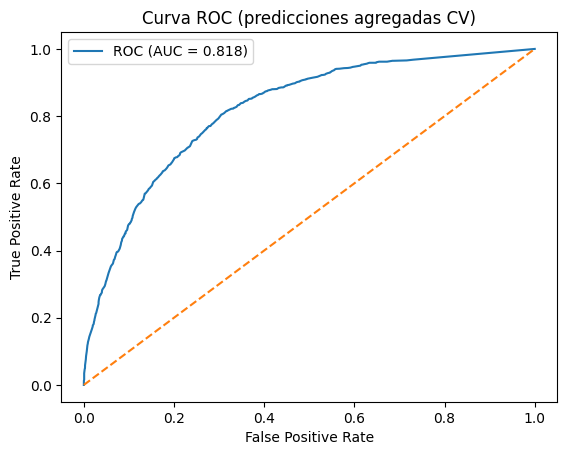

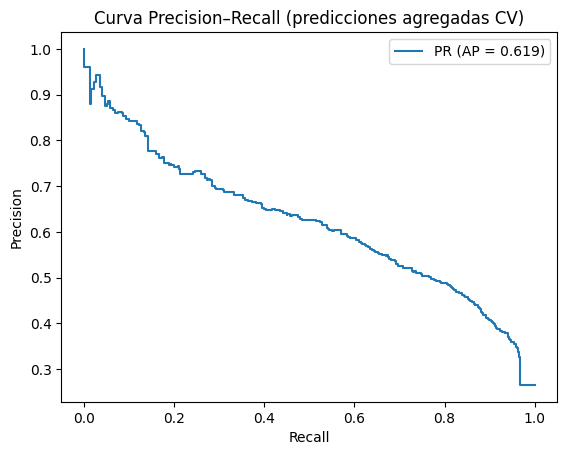

In [12]:
# Elegir el mejor entre Grid y Random por score
best_dt_search = grid_dt #Verificar
best_dt = best_dt_search.best_estimator_

print("Mejor método:", type(best_dt_search).__name__)
print("Mejores hiperparámetros:")
pprint(best_dt_search.best_params_)

df_dt, summary_dt, curves_dt = evaluate_model_cv_detailed(best_dt, X, y, cv=cv5, plot_curves=True, verbose=True)

### Evaluación del árbol de decisión seleccionado

El árbol de decisión seleccionado alcanza un AUC-ROC promedio de aproximadamente 0.82,
indicando una buena capacidad de discriminación entre clientes que abandonan y aquellos
que permanecen. Sin embargo, dada la naturaleza desbalanceada del problema, la métrica
más relevante es el área bajo la curva Precision–Recall, donde el modelo obtiene un
PR-AUC cercano a 0.62.

Las métricas por fold muestran una variabilidad acotada, lo que sugiere que el modelo
presenta un comportamiento estable. No obstante, el recall para la clase churn es
moderado (~0.54), lo que implica que una fracción relevante de clientes que abandonan
no es detectada por el modelo. Este resultado motiva la exploración de modelos de
ensamble y el uso de pesos por clase en etapas posteriores.


## Paso 3. Visualización del árbol óptimo

In [13]:
# Entrenar el mejor árbol en todo el dataset para visualizarlo
best_dt.fit(X, y)

dt_clf = best_dt.named_steps["clf"]
feature_names = get_feature_names_from_preprocessor(best_dt.named_steps["preprocess"])

len(feature_names), feature_names[:10]

(13618,
 ['num__SeniorCitizen',
  'num__tenure',
  'num__MonthlyCharges',
  'cat__customerID_0002-ORFBO',
  'cat__customerID_0003-MKNFE',
  'cat__customerID_0004-TLHLJ',
  'cat__customerID_0011-IGKFF',
  'cat__customerID_0013-EXCHZ',
  'cat__customerID_0013-MHZWF',
  'cat__customerID_0013-SMEOE'])

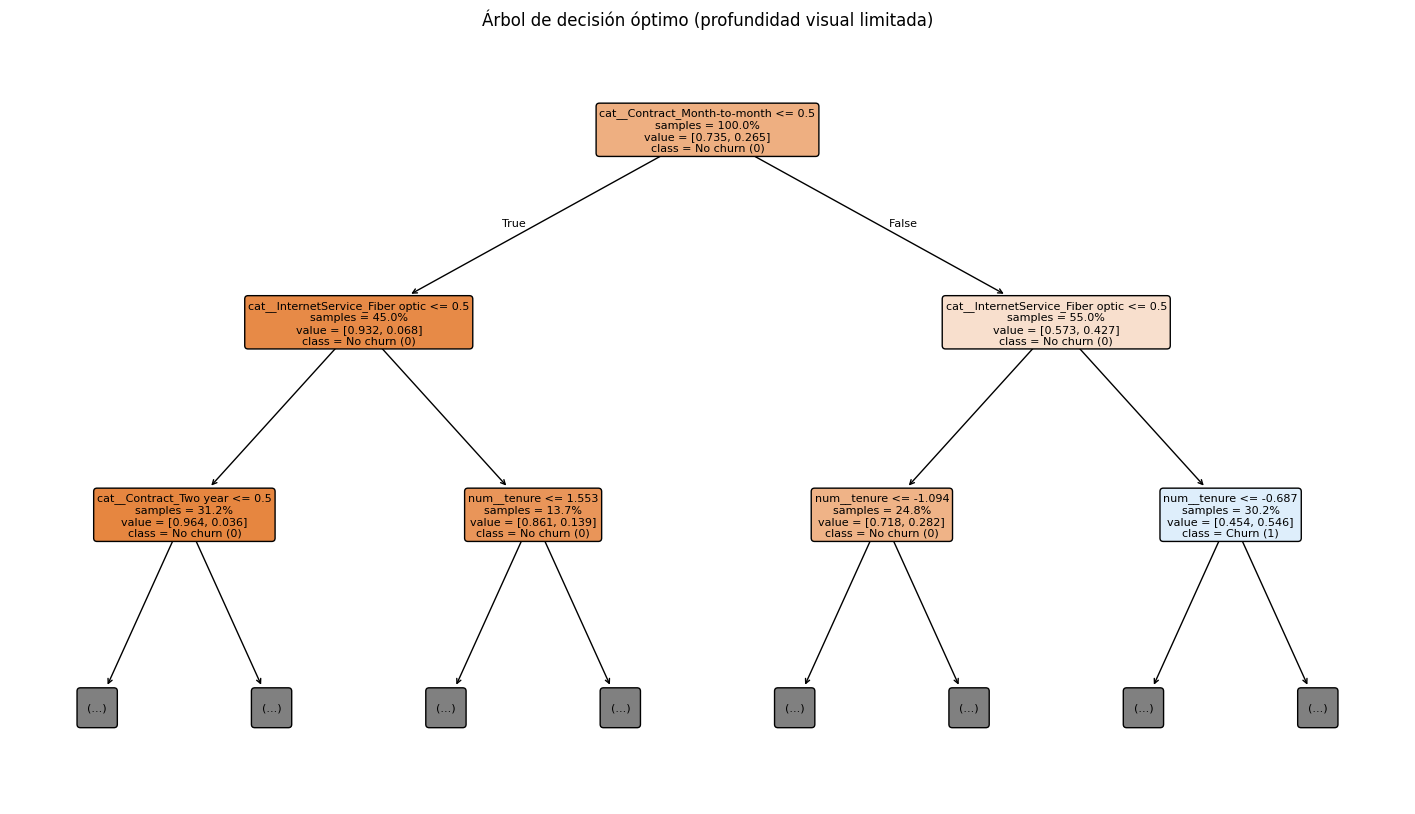

In [14]:
plt.figure(figsize=(18, 10))
plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=["No churn (0)", "Churn (1)"],
    filled=True,
    max_depth=2,           # ajustar según legibilidad
    impurity=False,
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión óptimo (profundidad visual limitada)")
plt.show()

### Visualización e interpretación del árbol de decisión

La visualización del árbol de decisión, limitada a las primeras profundidades para
mejorar su legibilidad, muestra que el tipo de contrato es la variable más influyente
en la predicción de churn. En particular, los clientes con contratos mes a mes presentan
una mayor probabilidad de abandono.

Otras variables relevantes en las primeras divisiones incluyen el tipo de servicio de
internet y la antigüedad del cliente, observándose que clientes con fibra óptica y baja
antigüedad presentan mayores tasas de churn. Estas reglas son intuitivas y fácilmente
interpretables, lo que constituye una ventaja del árbol de decisión frente a modelos
lineales como la regresión logística.


## Paso 5. Selección del mejor Random Forest (optimización de hiperparámetros)

In [16]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [32, 64, 128, 256],
    "clf__max_depth": [None, 5, 10, 15],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": [None, "balanced"]
}

# Random Search recomendado para reducir tiempo
rand_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=40,
    cv=cv5,
    scoring=scoring,   # PR-AUC
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_rf.fit(X, y)
rf_time = time.perf_counter() - t0

print("RandomizedSearchCV RF time (s):", round(rf_time, 3))
print("Best params (RF):")
pprint(rand_rf.best_params_)
print("Best score (RF, PR-AUC):", rand_rf.best_score_)

RandomizedSearchCV RF time (s): 284.357
Best params (RF):
{'clf__class_weight': 'balanced',
 'clf__max_depth': 10,
 'clf__max_features': None,
 'clf__min_samples_leaf': 10,
 'clf__n_estimators': 128}
Best score (RF, PR-AUC): 0.6553181009919834


### Selección del mejor Random Forest

Se utiliza RandomizedSearchCV para seleccionar los hiperparámetros del Random Forest,
debido al alto costo computacional de una búsqueda exhaustiva. El modelo seleccionado
incluye un número elevado de árboles (128) y utiliza pesos balanceados por clase, lo
que permite abordar explícitamente el desbalance presente en la variable objetivo.

El Random Forest alcanza un PR-AUC de aproximadamente 0.66, superando de forma clara
al árbol de decisión individual. Este resultado evidencia la capacidad de los modelos
de ensamble para reducir la varianza y mejorar la generalización.


,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,2.689144,0.069474,0.777147,0.559761,0.751337,0.641553,0.857162,0.683503
1,2,2.868893,0.090414,0.762952,0.539683,0.727273,0.619590,0.838026,0.650729
2,3,3.545885,0.088519,0.779276,0.564155,0.740642,0.640462,0.849014,0.678224
3,4,3.506418,0.085287,0.761364,0.537525,0.710456,0.612009,0.824375,0.608196
4,5,3.432111,0.089565,0.759233,0.535211,0.711230,0.610792,0.838972,0.655938


,mean,std
fit_time_s,3.208490,0.399265
pred_time_s,0.084652,0.008704
accuracy,0.767994,0.009450
precision,0.547267,0.013593
recall,0.728187,0.017985
f1,0.624881,0.015107
auc_roc,0.841510,0.012385
pr_auc,0.655318,0.029837



Matriz de confusión (global):
[[4048 1126]
 [ 508 1361]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.888     0.782     0.832      5174
           1      0.547     0.728     0.625      1869

    accuracy                          0.768      7043
   macro avg      0.718     0.755     0.728      7043
weighted avg      0.798     0.768     0.777      7043



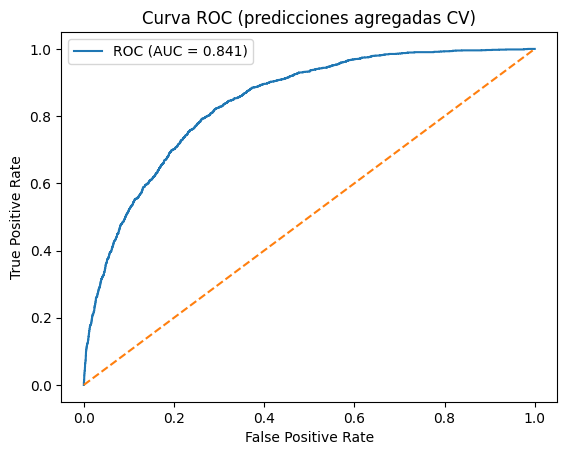

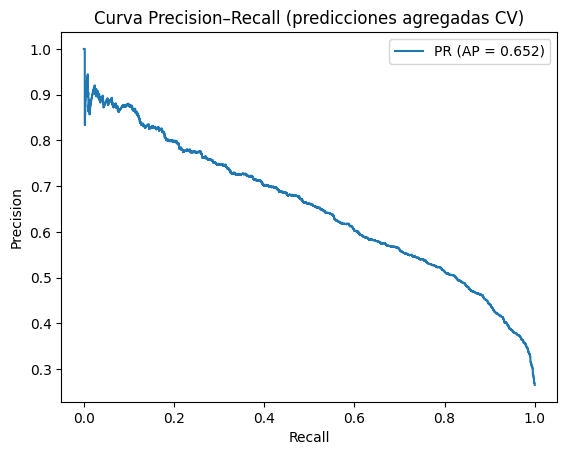

In [17]:
best_rf = rand_rf.best_estimator_
df_rf, summary_rf, curves_rf = evaluate_model_cv_detailed(best_rf, X, y, cv=cv5, plot_curves=True, verbose=True)

### Evaluación final del Random Forest

El Random Forest seleccionado alcanza un AUC-ROC promedio de aproximadamente 0.84 y un
PR-AUC cercano a 0.65, superando consistentemente al árbol de decisión individual. El
uso de pesos balanceados por clase incrementa significativamente el recall para la
clase churn, permitiendo identificar cerca del 73% de los clientes que abandonan.

Si bien el modelo presenta una menor precisión que el árbol individual, el aumento en
recall y F1-score lo convierte en una alternativa más adecuada desde una perspectiva
de negocio, donde el costo de no identificar clientes en riesgo suele ser mayor que el
de contactar clientes que finalmente no abandonan.


## Paso 6. Comparación final: Árbol vs Random Forest

In [18]:
# Resumen comparativo (métricas promedio)
summary_dt_comp = summary_dt.copy()
summary_dt_comp["model"] = "DecisionTree (best)"
summary_rf_comp = summary_rf.copy()
summary_rf_comp["model"] = "RandomForest (best)"

summary_all = pd.concat([summary_dt_comp.reset_index().rename(columns={"index":"metric"}),
                         summary_rf_comp.reset_index().rename(columns={"index":"metric"})],
                        ignore_index=True)

# Ordenar para lectura
summary_all = summary_all[["model","metric","mean","std"]].sort_values(["metric","model"])
summary_all

,model,metric,mean,std
2,DecisionTree (best),accuracy,0.788157,0.008696
10,RandomForest (best),accuracy,0.767994,0.009450
6,DecisionTree (best),auc_roc,0.819036,0.011911
14,RandomForest (best),auc_roc,0.841510,0.012385
5,DecisionTree (best),f1,0.574140,0.022547
13,RandomForest (best),f1,0.624881,0.015107
0,DecisionTree (best),fit_time_s,0.150398,0.011198
8,RandomForest (best),fit_time_s,3.208490,0.399265
7,DecisionTree (best),pr_auc,0.617570,0.034481
15,RandomForest (best),pr_auc,0.655318,0.029837


### Comparación final de modelos

La comparación entre el árbol de decisión y el Random Forest muestra que, si bien el
árbol individual presenta un menor costo computacional y una mayor precisión, el
Random Forest ofrece un desempeño predictivo superior en métricas clave para el
problema de churn. En particular, el Random Forest alcanza mayores valores de recall,
F1-score y PR-AUC, lo que indica una mejor capacidad para identificar clientes en
riesgo de abandono.

Desde una perspectiva de negocio, el aumento en recall resulta especialmente relevante,
ya que reduce la cantidad de clientes que abandonan sin ser detectados. A pesar de su
mayor costo computacional, el Random Forest se presenta como el modelo más adecuado
para campañas de retención, evidenciando además una menor varianza y mayor estabilidad
entre folds, en línea con la teoría de modelos de ensamble vista en clases.


## Paso 7. Discusión y conclusiones
1. Justificación de rangos de hiperparámetros (overfitting, complejidad, interpretabilidad).
2. Comparación Grid vs Random (tiempo y score).
3. Interpretación de splits más relevantes del árbol.
4. Análisis de varianza en Random Forest y su relación con bagging.
5. Métrica prioritaria para retención (desde perspectiva de negocio) y por qué.
